In [25]:
!CUDA_VISIBLE_DEVICES=6 torchrun --nproc_per_node=1 module8/visualize.py --lr=1e-4 --backbone_lr=0 \
--model_name=efficient14_freeze_swin --pre_norm --image_name=1123.jpg

Loading pre-mapped weights from ./pretrained_models/timm_swin_with_gdino_weights.pth
Found image '1123.jpg' at index 120
Gambar: 1123
Jumlah objek yang diprediksi: 814.13
Jumlah objek sebenarnya: 3701.00
Selisih: 2886.87


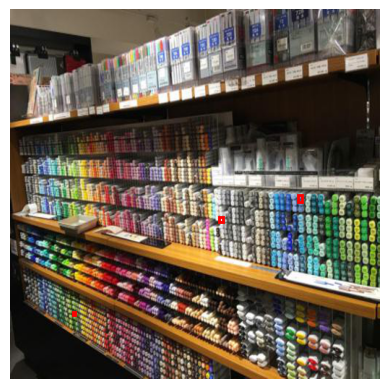

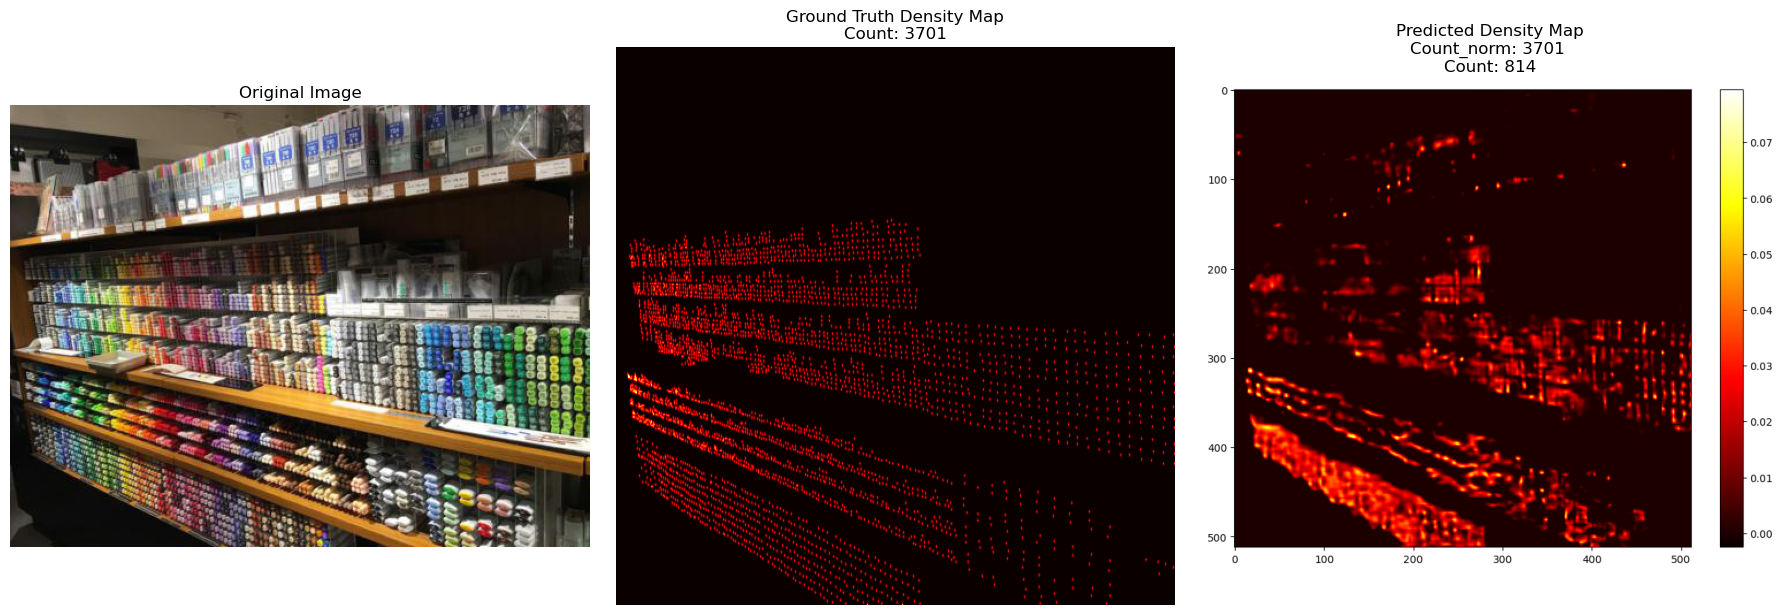

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
import matplotlib.patches as patches

# Path untuk dataset
data_path = '/home/renaldy_fredyan/PhDResearch/LOCA/Dataset/'
original_image_folder = os.path.join(data_path, "images_384_VarV2")
ground_truth_folder = os.path.join(data_path, "gt_density_map_adaptive_512_512_object_VarV2")
predicted_folder = "density_maps_prediction"

# Nama file gambar tanpa ekstensi
file_base_name = "1123"  # Ganti dengan nama file yang diinginkan tanpa ekstensi
original_image_path = os.path.join(original_image_folder, f"{file_base_name}.jpg")

# Fungsi untuk visualisasi bounding box dengan koordinat yang disesuaikan
def visualize_bounding_boxes(image_path, annotation, image_size=(512, 512)):
    # Load gambar asli untuk mendapatkan dimensi aslinya
    original_img = Image.open(image_path).convert("RGB")
    original_width, original_height = original_img.size

    # Resize gambar
    img = original_img.resize(image_size)
    resize_width, resize_height = image_size

    # Skala untuk menyesuaikan bounding box
    x_scale = resize_width / original_width
    y_scale = resize_height / original_height

    # Membuat plot
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Menampilkan setiap bounding box dari anotasi
    for bbox in annotation['box_examples_coordinates']:
        # Ekstraksi koordinat dan sesuaikan dengan skala
        y_min = min([point[1] for point in bbox]) * y_scale
        y_max = max([point[1] for point in bbox]) * y_scale
        x_min = min([point[0] for point in bbox]) * x_scale
        x_max = max([point[0] for point in bbox]) * x_scale

        # Hitung width dan height dengan benar
        width = abs(x_max - x_min)
        height = abs(y_max - y_min)

        # Buat rectangle bounding box
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none')
        
        # Tambahkan rectangle ke plot
        ax.add_patch(rect)

    # Tampilkan gambar dengan bounding box
    plt.axis("off")
    plt.show()

# Load anotasi dari file JSON
annotation_path = os.path.join(data_path, 'annotation_FSC147_384.json')
with open(annotation_path, 'r') as f:
    annotations = json.load(f)

# Ambil anotasi untuk gambar pertama
first_annotation = annotations.get(file_base_name + '.jpg')

# Visualisasi bounding box jika anotasi ada
if first_annotation:
    visualize_bounding_boxes(original_image_path, first_annotation, image_size=(512, 512))
else:
    print(f"Tidak ada anotasi untuk gambar {file_base_name}")

# Ambil density map ground truth
ground_truth_path = os.path.join(ground_truth_folder, f"{file_base_name}.npy")
ground_truth_density = np.load(ground_truth_path)

# Ambil density map prediksi dari file .png sebagai gambar
predicted_density_path = os.path.join(predicted_folder, f"{file_base_name}_prediction.png")
predicted_density_img = Image.open(predicted_density_path)

# Konversi predicted_density_img ke array numpy
predicted_density_np = np.array(predicted_density_img)

# Normalisasi density map prediksi agar sesuai dengan skala ground truth
predicted_density_norm = predicted_density_np / predicted_density_np.sum() * ground_truth_density.sum()

# Hitung jumlah objek pada ground truth dan prediksi
ground_truth_count = ground_truth_density.sum()
predicted_count_norm = predicted_density_norm.sum()

predicted_density = np.load(os.path.join(predicted_folder, f"{file_base_name}_predicted_density.npy"))
predicted_count = predicted_density.sum()

# Tampilkan ketiga gambar berdampingan
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Gambar asli
original_image = Image.open(original_image_path)
axes[0].imshow(original_image)
axes[0].set_title("Original Image")

# Density map ground truth
axes[1].imshow(ground_truth_density, cmap='hot')
axes[1].set_title(f"Ground Truth Density Map\nCount: {ground_truth_count:.0f}")

# Density map prediksi
axes[2].imshow(predicted_density_np, cmap='hot')
axes[2].set_title(f"Predicted Density Map\nCount_norm: {predicted_count_norm:.0f} \nCount: {predicted_count:.0f}")

# Hapus sumbu untuk tampilan lebih baik
for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()


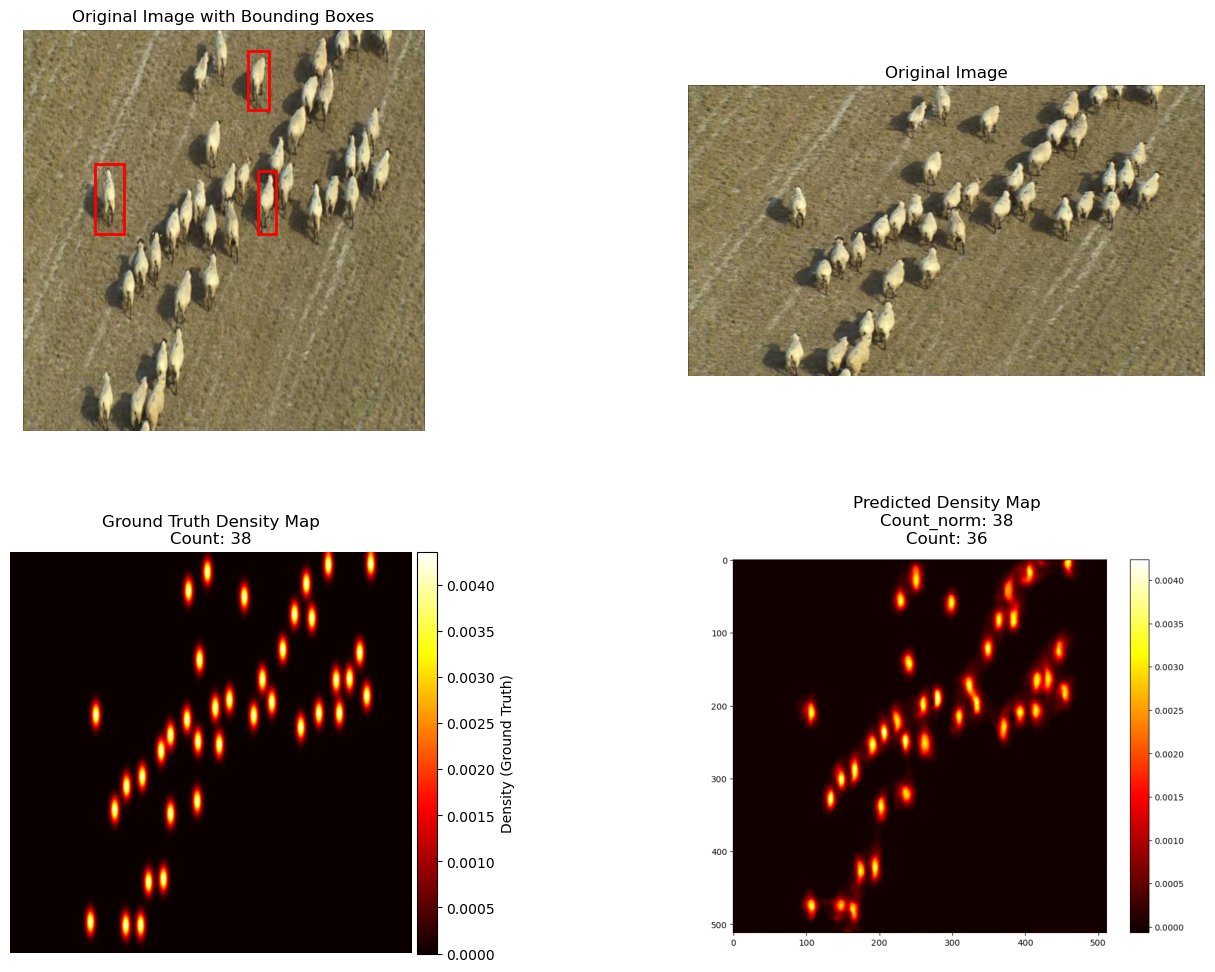

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Atur matplotlib agar tidak menampilkan warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Path untuk dataset
data_path = '/home/renaldy_fredyan/PhDResearch/LOCA/Dataset/'
original_image_folder = os.path.join(data_path, "images_384_VarV2")
ground_truth_folder = os.path.join(data_path, "gt_density_map_adaptive_512_512_object_VarV2")
predicted_folder = "density_maps_prediction"

# Nama file gambar tanpa ekstensi
file_base_name = "6901"  # Ganti dengan nama file yang diinginkan tanpa ekstensi
original_image_path = os.path.join(original_image_folder, f"{file_base_name}.jpg")

# Load semua data yang diperlukan
# Load gambar asli
original_image = Image.open(original_image_path)

# Load density map ground truth
ground_truth_path = os.path.join(ground_truth_folder, f"{file_base_name}.npy")
ground_truth_density = np.load(ground_truth_path)

# Load density map prediksi 
predicted_density_path = os.path.join(predicted_folder, f"{file_base_name}_prediction.png")
predicted_density_img = Image.open(predicted_density_path)
predicted_density_np = np.array(predicted_density_img)

# Normalisasi density map prediksi
predicted_density_norm = predicted_density_np / predicted_density_np.sum() * ground_truth_density.sum() if predicted_density_np.sum() > 0 else predicted_density_np

# Hitung jumlah objek
ground_truth_count = ground_truth_density.sum()
predicted_count_norm = predicted_density_norm.sum()

# Load predicted density dari file .npy jika tersedia
try:
    predicted_density = np.load(os.path.join(predicted_folder, f"{file_base_name}_predicted_density.npy"))
    predicted_count = predicted_density.sum()
except:
    predicted_count = predicted_count_norm

# Load anotasi dari file JSON untuk bounding box
annotation_path = os.path.join(data_path, 'annotation_FSC147_384.json')
with open(annotation_path, 'r') as f:
    annotations = json.load(f)
first_annotation = annotations.get(file_base_name + '.jpg')

# Fungsi untuk visualisasi bounding box
def add_bounding_boxes(ax, image_path, annotation, image_size=(512, 512)):
    # Load gambar asli
    original_img = Image.open(image_path).convert("RGB")
    original_width, original_height = original_img.size
    
    # Resize gambar untuk ditampilkan
    img = original_img.resize(image_size)
    resize_width, resize_height = image_size
    
    # Skala untuk menyesuaikan bounding box
    x_scale = resize_width / original_width
    y_scale = resize_height / original_height
    
    # Tampilkan gambar
    ax.imshow(img)
    
    # Tambahkan bounding box
    for bbox in annotation['box_examples_coordinates']:
        # Ekstraksi koordinat dan sesuaikan dengan skala
        y_min = min([point[1] for point in bbox]) * y_scale
        y_max = max([point[1] for point in bbox]) * y_scale
        x_min = min([point[0] for point in bbox]) * x_scale
        x_max = max([point[0] for point in bbox]) * x_scale
        
        # Hitung width dan height
        width = abs(x_max - x_min)
        height = abs(y_max - y_min)
        
        # Buat dan tambahkan rectangle
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
    
    return ax

# Perbarui figure dan tambahkan white_space untuk memberi ruang bagi colorbars
fig, axes = plt.subplots(2, 2, figsize=(16, 12), gridspec_kw={'wspace': 0.4, 'hspace': 0.3})

# Gambar 1: Original image dengan bounding box (kiri atas)
if first_annotation:
    add_bounding_boxes(axes[0, 0], original_image_path, first_annotation)
    axes[0, 0].set_title("Original Image with Bounding Boxes")
else:
    axes[0, 0].imshow(original_image)
    axes[0, 0].set_title("Original Image (No Annotations Found)")

# Gambar 2: Original image tanpa bounding box (kanan atas)
axes[0, 1].imshow(original_image)
axes[0, 1].set_title("Original Image")

# Gambar 3: Ground Truth Density Map (kiri bawah)
im3 = axes[1, 0].imshow(ground_truth_density, cmap='hot')
axes[1, 0].set_title(f"Ground Truth Density Map\nCount: {ground_truth_count:.0f}")

# Gambar 4: Predicted Density Map (kanan bawah)
im4 = axes[1, 1].imshow(predicted_density_np, cmap='hot')
axes[1, 1].set_title(f"Predicted Density Map\nCount_norm: {predicted_count_norm:.0f}\nCount: {predicted_count:.0f}")

# Hilangkan sumbu pada semua subplot
for ax in axes.flat:
    ax.axis('off')

# Tambahkan colorbar yang sama untuk kedua density map
# Gunakan gridspec untuk posisi yang lebih baik
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Pastikan kedua density map menggunakan skala yang sama
vmin = min(ground_truth_density.min(), predicted_density_np.min())
vmax = max(ground_truth_density.max(), predicted_density_np.max())

# Tampilkan ground truth density map dengan normalisasi yang tepat
im3 = axes[1, 0].imshow(ground_truth_density, cmap='hot')
axes[1, 0].set_title(f"Ground Truth Density Map\nCount: {ground_truth_count:.0f}")

# Tampilkan predicted density map
im4 = axes[1, 1].imshow(predicted_density_np, cmap='hot')
axes[1, 1].set_title(f"Predicted Density Map\nCount_norm: {predicted_count_norm:.0f}\nCount: {predicted_count:.0f}")

# Tambahkan colorbar untuk masing-masing density map
# Ground truth colorbar
divider1 = make_axes_locatable(axes[1, 0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = fig.colorbar(im3, cax=cax1)
cbar1.set_label('Density (Ground Truth)')

# # Predicted density colorbar
# divider2 = make_axes_locatable(axes[1, 1])
# cax2 = divider2.append_axes("right", size="5%", pad=0.05)
# cbar2 = fig.colorbar(im4, cax=cax2)
# cbar2.set_label('Density (Predicted)')

# Gunakan adjust subplots dengan ruang yang lebih tepat
plt.subplots_adjust(wspace=0.4, hspace=0.3, right=0.9)

# Simpan gambar
# plt.savefig(f"{file_base_name}_visualization.png", dpi=300, bbox_inches='tight')
plt.show()